For this homework, make sure that you format your notbook nicely and cite all sources in the appropriate sections. Programmatically generate or embed any figures or graphs that you need.

Names: __Shaan Hossain, Jinesh Shailesh Mehta__

TODO List and Planning:

Last Updated:11th Nov

Tasks:
- Update the answer for similar and constrasts for the two selected dataset
- Update the answer for text normalization and pre-processing
- Update the analysis answer for different generated graphs (embeddings and word clusters 2D)

Shaan:

Jinesh:

For next time:

- Analysis on the images
- Training feed forward neural network
- Generation of sentences and comparing sentences


Step 1: Train your own word embeddings
--------------------------------

(describe the provided dataset that you have chosen here)

__From the given two choices, we have [Spooky Authors Dataset](https://www.kaggle.com/c/spooky-author-identification).__

Describe what data set you have chosen to compare and contrast with the your chosen provided dataset. Make sure to describe where it comes from and it's general properties.

(describe your dataset here)
<b>
- Our selected data: [Coronavirus tweets NLP](https://www.kaggle.com/datatattle/covid-19-nlp-text-classification)
- Description : The tweets have been pulled from Twitter and manual tagging has been done then. The names and usernames have been given codes to avoid any privacy concerns.
- Columns: 
    - UserName
    - ScreenName
    - Location
    - TweetAt
    - OriginalTweet
    - Sentiment
- Similarities with chosen provided dataset: TODO: Update similarities
- Constrasts with chosen provided dataset: TODO: Update constrasts</b>

In [190]:
# import your libraries here
from typing import List, Dict
# libs used for preprocessing
from gensim.parsing.preprocessing import stem_text, remove_stopwords, strip_punctuation
from nltk.tokenize import RegexpTokenizer
from nltk import ngrams
# libs used for file reading and parsing
from csv import reader
# libs used for plotting
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
# libs used for generating word2vec models
from gensim.models import Word2Vec
# to compute the training using multiple threads
from multiprocessing import cpu_count
# other utilities
from pathlib import Path
from collections import Counter
from os import path
# libs used for validating the word vectors and loading word vectors
from gensim.models import KeyedVectors
import numpy as np
# import keras
# import numpy 
# import pandas
# import scipy
# import sklearn

### a) Train embeddings on GIVEN dataset : Spooky Dataset

#### 1. Function to parse data from training files

In [191]:
# Read the file and prepare the training data 
# so that it is in the following format

data = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
			['this', 'is', 'the', 'second', 'sentence'],
			['yet', 'another', 'sentence'],
			['one', 'more', 'sentence'],
			['and', 'the', 'final', 'sentence']]

def parse_data(training_file_path: str, percentage: int, select_column:int) -> List[str]:
  """This function is used to parse input lines
  and returns a the provided percent of data.

  Args:
      lines (List[str]): list of lines
      percentage (int): percent of the dataset needed
      select_column (int): column to be selected from the dataset
  Returns:
      List[str]: lines (percentage of dataset)
  """
  sentences = []
  percentage_sentences = []
  with open(training_file_path, "r", encoding="utf8", errors="ignore") as csvfile:
    csv_reader = reader(csvfile)
    #skipping header
    header = next(csv_reader)

    # line_length = len(list(csv_reader_copy))
   
    if header != None:
      for row in csv_reader:
        sentences.append(row[select_column])

    end_of_data = int(len(sentences) * percentage * .01)
    percentage_sentences = sentences[0:end_of_data]

  return percentage_sentences

#### 2. Function to do preprocessing for the parsed data.
    - Lower word case
    - Remove stopwords
    - Remove punctuations
    - Tokenize line and add sentence seperator tokens

In [192]:
def preprocessing(running_lines: List[str]) -> List[List[str]]:
  """This function takes in the running test and return back the
  preprocessed text. Four tasks are done as part of this:
    1. lower word case
    2. remove stopwords
    3. remove punctuation
    4. Add <s> and </s> for every sentence

  Args:
      running_lines (List[str]): list of lines

  Returns:
      List[List[str]]: list of sentences where each sentence is broken
                        into list of words.
  """
  preprocessed_lines = []
  tokenizer = RegexpTokenizer(r'\w+')
  for line in running_lines:
    lower_case_data = line.lower()
    data_without_stop_word = remove_stopwords(lower_case_data)
    data_without_punct = strip_punctuation(data_without_stop_word)
    processed_data = tokenizer.tokenize(data_without_punct)
    processed_data.insert(0,"<s>")
    processed_data.append("</s>")
    preprocessed_lines.append(processed_data)
  return preprocessed_lines

#### 3. Computing the parsing and preprocessing for both the datasets.

In [193]:
# parse and preprocess provided data
print("Tokenizing Provided Dataset: Spooky Dataset\n")
spooky_sentences = preprocessing(parse_data("data/provided/train/train.csv", 20, 1))
for token in spooky_sentences:
  print(token)

#parse and preprocess custom data
print("\nTokenizing Custom Dataset: Corona Tweets\n")
covid_sentences = preprocessing(parse_data("data/custom/train/Corona_NLP_train.csv", .01, 4))
for token in covid_sentences:
  print(token)

Tokenizing Provided Dataset: Spooky Dataset

['<s>', 'process', 'however', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', 'circuit', 'return', 'point', 'set', 'out', 'aware', 'fact', 'perfectly', 'uniform', 'wall', '</s>']
['<s>', 'occurred', 'fumbling', 'mere', 'mistake', '</s>']
['<s>', 'left', 'hand', 'gold', 'snuff', 'box', 'which', 'capered', 'hill', 'cutting', 'manner', 'fantastic', 'steps', 'took', 'snuff', 'incessantly', 'air', 'greatest', 'possible', 'self', 'satisfaction', '</s>']
['<s>', 'lovely', 'spring', 'looked', 'windsor', 'terrace', 'sixteen', 'fertile', 'counties', 'spread', 'beneath', 'speckled', 'happy', 'cottages', 'wealthier', 'towns', 'looked', 'years', 'heart', 'cheering', 'fair', '</s>']
['<s>', 'finding', 'else', 'gold', 'superintendent', 'abandoned', 'attempts', 'perplexed', 'look', 'occasionally', 'steals', 'countenance', 'sits', 'thinking', 'desk', '</s>']
['<s>', 'youth', 'passed', 'solitude', 'best', 'years', 'spent', 'gentle', 'feminine', 

#### 4. Provide functionality for generating word embeddings for a given model.

__Note: For the Word2Vec model training, we are using Skip Gram model as shown with value sg in the below code. Also, we are keep generating the vocab in sorted order (descending).__

In [194]:
# The dimension of word embedding. 
# This variable will be used throughout the program
# you may vary this as you desire
EMBEDDINGS_SIZE = 200

# Train the Word2Vec model from Gensim. 
# Below are the hyperparameters that are most relevant. 
# But feel free to explore other 
# options too:
sg = 1 # The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.
window = 5
size = EMBEDDINGS_SIZE
min_count = 1
workers = cpu_count()
sorted_vocab = 1 #1 for descending order

def generate_embeddings(model_name: str, sentences: List[List[str]]) -> (str, str):
    """This function is used to generate embeddings (model and word vectors) for a given
    model name and provided sentences.

    Args:
        model_name (str): name of the model
        sentences (List[List[str]]): sentences to be used for model creation

    Returns:
        str, str : model path and word vector path
    """
    #generate word2vec model
    model = Word2Vec(
        sentences=sentences, 
        vector_size=size, 
        window=window, 
        min_count=min_count, 
        workers=workers, 
        sg=sg,
        sorted_vocab=sorted_vocab)
    # save model
    model_file_name = f'word2vec.{model_name}.model'
    model_path = f'{model_name}/model'
    # make sure all the parent folders exists 
    Path(model_path).mkdir(parents=True, exist_ok=True)
    model_file_path = f'{model_path}/{model_file_name}'
    model.save(model_file_path)
    # Store just the words + their trained embeddings.
    word_vectors_file_name = f'word2vec.{model_name}.wordvectors'
    word_vectors = model.wv
    word_vectors_path = f'{model_name}/wordvectors'
    # make sure all the parent folders exists 
    Path(word_vectors_path).mkdir(parents=True, exist_ok=True)
    word_vectors_file_path = f'{word_vectors_path}/{word_vectors_file_name}'
    word_vectors.save(word_vectors_file_path)
    return model_file_path, word_vectors_file_path

#### 5. Generate model and word vectors for Spooky dataset

In [195]:
spooky_model_path, spooky_word_vectors_path = generate_embeddings("spooky", spooky_sentences)
# enable below code to see the word vector of 'process' word in spooky

# spooky_wv = KeyedVectors.load(spooky_word_vectors_path, mmap='r')
# process_word_vector = spooky_wv['process']
# print(process_word_vector)

#### 6. Display the vocabulary size for Spooky and Covid dataset

In [196]:
# print out the vocabulary size for spooky dataset
spooky_model = Word2Vec.load(spooky_model_path)
print('Vocab size: {} for Spooky Dataset.'.format(len(spooky_model.wv)))


Vocab size: 12327 for Spooky Dataset.


#### 7. Saving the word embeddings in a text file (load later if needed)

In [197]:
# You can save file in txt format, then load later if you wish.
# make sure all the parent folders exists 
spooky_embeddings_folder_path = 'spooky/embeddings'
Path(spooky_embeddings_folder_path).mkdir(parents=True, exist_ok=True)
spooky_model.wv.save_word2vec_format(f'{spooky_embeddings_folder_path}/spooky_embeddings.txt', binary=False)

### b) Train embedding on YOUR dataset

In [198]:
# then do a second data set

#generate model and word vectors for covid dataset
covid_model_path, covid_word_vectors_path = generate_embeddings("covid", covid_sentences)

#enable below code to see the word vector of 'neighbours' word in covid
# covid_wv = KeyedVectors.load(covid_word_vectors_path, mmap='r')
# neighbours_word_vector = covid_wv['neighbours']
# print(neighbours_word_vector)

#print out the vocabulary size for covid dataset
covid_model = Word2Vec.load(covid_model_path)
print('Vocab size: {} for Covid Dataset.'.format(len(covid_model.wv)))

# save embeddings
covid_embeddings_folder_path = 'covid/embeddings'
Path(covid_embeddings_folder_path).mkdir(parents=True, exist_ok=True)
covid_model.wv.save_word2vec_format(f'{covid_embeddings_folder_path}/covid_embeddings.txt', binary=False)

Vocab size: 64 for Covid Dataset.


What text-normalization and pre-processing did you do and why?

- Text Normalization and Pre-processing steps done:
    - Lower word case
    - Remove stopwords
    - Remove punctuations
    - Tokenize line and add sentence seperator tokens

Step 2: Evaluate the differences between the word embeddings
----------------------------

(make sure to include graphs, figures, and paragraphs with full sentences)

Produce any graphs or figures that illustrate what you have found and write 2 - 3 paragraphs describing the differences you find between your two sets of embeddings and why you see them.


#### 1. Get top k frequent words from the parsed data

In [199]:
def generate_vocab(sentences:List[List[str]]):
    """This function is used to generate vocabs from the given sentences.

    Args:
        sentences (List[str]): sentences

    Returns:
        dict: word with each having count
    """
    word_counts = Counter()
    for sentence in sentences:
        for i in sentence:
            word_counts[i] += 1
    return word_counts

def get_top_k_words(sentences:str, k:int):
    """This function is used to get top k word from the given
    sentences.

    Args:
        sentences (str): list of all the sentences to be used for count
        k (int): top k words (max frequency)

    Returns:
        Dict[str, int]: k words with their count
    """
    word_counts = generate_vocab(sentences)
    word_counts["<s>"] = 0
    word_counts["</s>"] = 0
    k_most_common = []
    for i in word_counts.most_common(k):
        k_most_common.append(i[0])
    print(word_counts.most_common(k)) #Seeing the corresponding counts
    return k_most_common

#### 2. Generate keys for both the datasets: Spooky and Covid

In [200]:
# for spooky dataset
wv_spooky = KeyedVectors.load(spooky_word_vectors_path, mmap='r')
spooky_keys  = get_top_k_words(spooky_sentences, 10)
# print(spooky_keys) 
# print(spooky_model.wv.most_similar(spooky_keys[0], topn=10))

# for covid dataset
wv_covid = KeyedVectors.load(covid_word_vectors_path, mmap='r')
covid_keys  = get_top_k_words(covid_sentences, 10)
# print(spooky_keys) 
# print(model.wv.most_similar(keys[0], topn=10))

[('s', 258), ('me', 183), ('it', 168), ('said', 159), ('time', 136), ('man', 130), ('old', 127), ('like', 121), ('little', 112), ('great', 108)]
[('t', 6), ('https', 5), ('co', 5), ('neighbours', 2), ('phone', 2), ('numbers', 2), ('shopping', 2), ('coronavirus', 2), ('covid', 2), ('19', 2)]


#### 3. Define embedding clusters and word clusters


In [201]:
def generate_embeddings_word_clusters(model, keys):
    '''
    This function is used to generate embedding and word clusters
    for the given model and the respective keys.

    Args:
        model (word2vec): model to be used
        keys (Dict): keys which are most frequent in the model

    Returns:
        List, List: embedding and word cluster
    '''
    embedding_clusters = []
    word_clusters = []
    for word in keys:
        embeddings = []
        words = []
        # print(model.wv.most_similar(word, topn=10))
        for similar_word, _ in model.wv.most_similar(word, topn=10):
            words.append(similar_word)
            embeddings.append(model.wv[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
    return embedding_clusters, word_clusters

#### 4. Define t-sne projection function

In [202]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, perplexity, filename=None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    tsne_model_en_2d = TSNE(perplexity=perplexity, n_components=2, init='pca', n_iter=3500, random_state=32)
    embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embeddings_en_2d, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

#### 5. Generate embedding and word clusters. Also, generate 2d projections for spooky and covid dataset.

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you inte

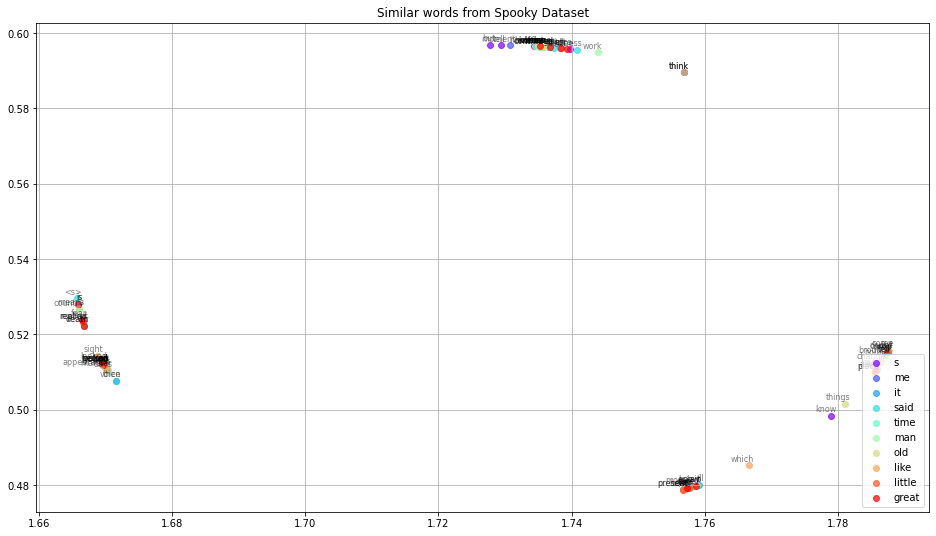

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you inte

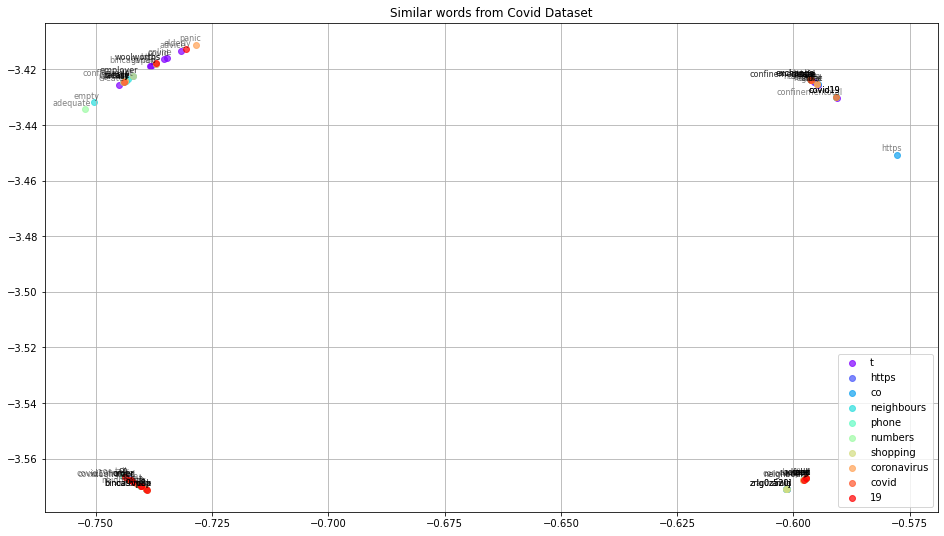

In [203]:
perplexity = 100

#spooky
spooky_embeddings_clusters, spooky_word_clusters = generate_embeddings_word_clusters(spooky_model, spooky_keys)
# for i in range(1, 30, 3):
#     file_name = 'similar_words_perplexity_' + str(i) + '.png'
#     tsne_plot_similar_words('Similar words from Spooky Dataset', keys, embedding_clusters, word_clusters, 0.7, i,
#     file_name)
spooky_folder_path = "spooky/images"
Path(spooky_folder_path).mkdir(parents=True, exist_ok=True)
spooky_file_path = f'{spooky_folder_path}/similar_words_perplexity_{perplexity}.png'
tsne_plot_similar_words('Similar words from Spooky Dataset', spooky_keys, spooky_embeddings_clusters, spooky_word_clusters, 0.7, perplexity,
    spooky_file_path)

# #covid
covid_embeddings_clusters, covid_word_clusters = generate_embeddings_word_clusters(covid_model, covid_keys)
covid_folder_path = "covid/images"
Path(covid_folder_path).mkdir(parents=True, exist_ok=True)
covid_file_path = f'{covid_folder_path}/similar_words_perplexity_{perplexity}.png'
tsne_plot_similar_words('Similar words from Covid Dataset', covid_keys, covid_embeddings_clusters, covid_word_clusters, 0.7, perplexity,
    covid_file_path)

#### 7. Produce any graphs or figures that illustrate what you have found and write 2 - 3 paragraphs describing the differences you find between your two sets of embeddings and why you see them.
(Write down your analysis)

Ans: TODO - Update the analysis answer here


Cite your sources:
-------------

Step 3: Feedforward Neural Language Model
--------------------------

### a) First, encode  your text into integers

#### 1. Define a function that would convert text to seqeunces

In [204]:
def texts_to_sequences(tokenized_sentences:List[List[str]], vocab_index_mapping:dict) -> List[List[int]]:
    """This function is used to generate sequences from the given texts.

    Args:
        tokenized_sentences (List[List[str]]): list of list of tokens (all sentences)
        vocab_index_mapping (dict): vocab mapped to index

    Returns:
        List[List[int]]: list of encoded sentences
    """
    encoded_sentences = []
    for sentence in tokenized_sentences:
        encoded_sentence = []
        for token in sentence:
            encoded_sentence.append(vocab_index_mapping[token])
        encoded_sentences.append(encoded_sentence)
    return encoded_sentences

#### 2. Generate Spooky and Covid encoded sentences

In [221]:
# Importing utility functions from Keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import LSTM
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall
import tensorflow as tf

# The size of the ngram language model you want to train
# change as needed for your experiments
NGRAM = 3 

# It is used to vectorize a text corpus. Here, it just creates a mapping from 
# word to a unique index. (Note: Indexing starts from 0)
# Example:
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(data)
# encoded = tokenizer.texts_to_sequences(data)

spooky_vocab = list(generate_vocab(spooky_sentences).keys())
# word -> index
spooky_vocab_index_mapping = {word:index for index, word in enumerate(spooky_vocab)}
spooky_encoded_sentences = texts_to_sequences(spooky_sentences, spooky_vocab_index_mapping)
# for sentence in spooky_encoded_sentences:
#     print(sentence)

covid_vocab = list(generate_vocab(covid_sentences).keys())
covid_vocab_index_mapping = {word:index for index, word in enumerate(covid_vocab)}
covid_encoded_sentences = texts_to_sequences(covid_sentences, covid_vocab_index_mapping)
# for sentence in covid_encoded_sentences:
#     print(sentence)       

### b) Next, prepare your sequences from text

#### Fixed ngram based sequences 

#### 3. Define function to generate ngrams from training samples

In [206]:
def generate_ngram_training_samples(encoded_sentences: list) -> list:
    """Takes the encoded data (list of lists) and 
    generates the training samples out of it.

    Args:
        encoded_sentences (list): encoded sentences

    Returns:
        list: generated ngrams from encoded sentences 
        - list of lists in the format [[x1, x2, ... , x(n-1), y], ...]
    """    
    generated_ngrams_list = []
    for sentence in encoded_sentences:
        generated_ngrams_list.append(list(ngrams(sentence, NGRAM + 1)))

    #enable to print generated ngrams
    # for generated_ngrams in generated_ngrams_list:
    #     for generated_ngram in generated_ngrams:
    #         print(generated_ngram)

    return generated_ngrams_list

#### 4. Generating ngrams for spooky and covid encoded sentences.

In [207]:
spooky_ngrams = generate_ngram_training_samples(spooky_encoded_sentences)
covid_ngrams = generate_ngram_training_samples(covid_encoded_sentences)

### c) Then, split the sequences into X and y and create a Data Generator

#### 5. Defining function to split ngrams into X and Y.

In [208]:
# Note here that the sequences were in the form: 
# sequence = [x1, x2, ... , x(n-1), y]
# We still need to separate it into [[x1, x2, ... , x(n-1)], ...], [y1, y2, ...]

def split_ngram_to_training_sample(generated_ngrams: list):
    """This function is used to split the provided n grams into X and Y.

    Args:
        generated_ngrams (list): ngrams to be splitted

    Returns:
        X, Y: List X, List Y
    """
    generated_n_grams_copy = generated_ngrams.copy()
    X = []
    Y = []
    for ngrams in generated_n_grams_copy:
        for ngram in ngrams:
            ngram = list(ngram)
            Y.append(ngram.pop(len(ngram) - 1))
            X.append(ngram)
    return X, Y

#### 6. Generating X and Y from generated ngrams for spooky and covid datasets.

In [209]:
spooky_X, spooky_Y = split_ngram_to_training_sample(spooky_ngrams)
# for i in range(0, len(spooky_X)):
#     print("X: " + str(spooky_X[i]))
#     print("Y: " + str(spooky_Y[i]))

# print(spooky_X)
# print(spooky_Y)

covid_X, covid_Y = split_ngram_to_training_sample(covid_ngrams)
# for i in range(0, len(covid_X)):
#     print("X: " + str(covid_X[i]))
#     print("Y: " + str(covid_X[i]))

# print(covid_X)
# print(covid_Y)

#### 7. Defining a function to convert X and Y from ngrams representation to embedddings representation

In [210]:
def convert_ngrams_to_embeddings(X_ngrams :List, Y_grams:List, vocabulary_index:Dict, word_embeddings:Dict):
    """This function is used to convert the provided ngrams into encoding representation 
    and for that, use the already created vocabulary_index dict and word embedding mappings.

    Args:
        X_ngrams (List): list of X ngrams
        Y_grams (List): list of Y ngrams
        vocabulary_index (Dict): vocab mapped to index
        word_embeddings (Dict): word mapped to embedding

    Returns:
        X, Y: X and Y (having embedding representation)
    """
    # you may find generating the following two dicts useful:
    # word to embedding : {'the':[0....], ...}
    # index to embedding : {1:[0....], ...} 
    # use your tokenizer's word_index to find the index of
    # a given word
    
    #For X
    X_sentences_embeddings = []
    for items in X_ngrams:
        X_sentence_embeddings = []
        for index in items:
            word = vocabulary_index[index]
            embeddings = word_embeddings[word]
            X_sentence_embeddings.extend(embeddings)
        X_sentences_embeddings.append(X_sentence_embeddings)
        
    #For Y       
    Y_total_embeddings = to_categorical(Y_grams)
            
    return X_sentences_embeddings, Y_total_embeddings

#### 8. Converting X and Y from ngrams representation to embedddings representation from Spooky and Covid dataset

In [211]:
spooky_X_embeddings, spooky_Y_embeddings = convert_ngrams_to_embeddings(spooky_X, spooky_Y,spooky_vocab,wv_spooky)

# covid_X_embeddings, covid_Y_embeddings = convert_ngrams_to_embeddings(covid_X, covid_Y, covid_vocab, wv_covid)

#### 9. Defining a data generator for given X, Y and batch size

In [212]:
def data_generator(X_embeddings: list, y_embeddings: list, num_sequences_per_batch: int) -> (list,list):
    '''
    Returns data generator to be used by feed_forward
    https://wiki.python.org/moin/Generators
    https://realpython.com/introduction-to-python-generators/
    
    Yields batches of embeddings and labels to go with them.
    Use one hot vectors to encode the labels 
    (see the to_categorical function)
    
    '''
    steps_per_epochs = len(X_embeddings)/num_sequences_per_batch
    current_step = 0
    while True:
        start_cell = (int(current_step % steps_per_epochs)) * num_sequences_per_batch
        end_cell = (int(current_step % steps_per_epochs) + 1) * num_sequences_per_batch
        yield np.array(X_embeddings[start_cell:end_cell]),np.array(y_embeddings[start_cell:end_cell])
        current_step += 1

#### 10. Creating a data generator for given X, Y and batch size

In [213]:
# Examples
# initialize data_generator
num_sequences_per_batch = 1280 # this is the batch size
steps_per_epoch = len(spooky_X_embeddings)//num_sequences_per_batch  # Number of batches per epoch
# train_generator = data_generator(X, y, num_sequences_per_batch)

# sample=next(train_generator) # this is how you get data out of generators
# sample[0].shape # (batch_size, (n-1)*EMBEDDING_SIZE)  (128, 200)
# sample[1].shape   # (batch_size, |V|) to_categorical

spooky_generator = data_generator(spooky_X_embeddings, spooky_Y_embeddings ,num_sequences_per_batch)
spooky_sample = next(spooky_generator)
print(spooky_sample[0].shape)
print(spooky_sample[1].shape)

# covid_generator = data_generator(covid_X_embeddings, covid_Y_embeddings ,num_sequences_per_batch)
# covid_sample = next(covid_generator)
# print(covid_sample[0].shape)
# print(covid_sample[1].shape)

(1280, 600)
(1280, 12327)


### d) Train your models

In [223]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import LSTM
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall
import tensorflow as tf

# code to train a feedforward neural language model 
# on a set of given word embeddings
# make sure not to just copy + paste to train your two models

# Define the model architecture using Keras Sequential API

# code to train a feedforward neural language model 
# on a set of given word embeddings
# make sure not to just copy + paste to train your two models

# print(np.array(spooky_X_embeddings).shape)
# print(np.array(spooky_Y_embeddings).shape)
# print(len(spooky_X[0]))
# print(len(spooky_X_embeddings))
# print(len(spooky_X_embeddings[0]))

# Define the model architecture using Keras Sequential API
spooky_model = Sequential()
spooky_model.add(Input((len(spooky_X_embeddings), NGRAM*EMBEDDINGS_SIZE)))
spooky_model.add(LSTM(units=20, return_sequences=False, return_state=True))
spooky_model.add(Dense(NGRAM*EMBEDDINGS_SIZE, activation='relu'))
spooky_model.add(Dense(len(spooky_vocab), activation='softmax'))

# ds_train = tf.data.Dataset.from_generator(lambda: data_generator(spooky_X_embeddings, spooky_Y_embeddings, num_sequences_per_batch), types, shapes).shuffle(1000).batch(32)

print(spooky_model.summary())

ValueError: All layers in a Sequential model should have a single output tensor. For multi-output layers, use the functional API.

In [215]:
# Start training the model
# tf.debugging.set_log_device_placement(True)
print("Model Compiling")
spooky_model.compile(loss=CategoricalCrossentropy(), optimizer=SGD(learning_rate=.02), metrics=['accuracy'])
print("Model Training")
spooky_generator = data_generator(spooky_X_embeddings, spooky_Y_embeddings, num_sequences_per_batch)
spooky_model.fit(x=spooky_generator, steps_per_epoch=steps_per_epoch, epochs=10)

Model Compiling
Model Training
Epoch 1/10
33/33 [==============================] - 11s 324ms/step - loss: 9.4120 - accuracy: 0.0520
Epoch 2/10
33/33 [==============================] - 9s 283ms/step - loss: 9.3951 - accuracy: 0.0902
Epoch 3/10
33/33 [==============================] - 9s 281ms/step - loss: 9.3770 - accuracy: 0.0906
Epoch 4/10
33/33 [==============================] - 9s 286ms/step - loss: 9.3572 - accuracy: 0.0906
Epoch 5/10
33/33 [==============================] - 9s 288ms/step - loss: 9.3345 - accuracy: 0.0907
Epoch 6/10
33/33 [==============================] - 10s 301ms/step - loss: 9.3087 - accuracy: 0.0903
Epoch 7/10
33/33 [==============================] - 10s 307ms/step - loss: 9.2769 - accuracy: 0.0906
Epoch 8/10
33/33 [==============================] - 10s 309ms/step - loss: 9.2390 - accuracy: 0.0906
Epoch 9/10
 6/33 [====>.........................] - ETA: 8s - loss: 9.2211 - accuracy: 0.0872

KeyboardInterrupt: 

### e) Generate Sentences

In [ ]:
# generate a sequence from the model

test_sentence = spooky_X[500]
gold_label = spooky_Y[999]
# print(test_sentence)
# print(gold_label)

# print(spooky_vocab[:20])

word_to_index_mapping = {}

def generate_seq(model: Sequential, 
                 tokenizer: Tokenizer, 
                 seed: list, 
                 n_words: int):
    '''
    Parameters:
        model: your neural network
        tokenizer: the keras preprocessing tokenizer
        seed: [w1, w2, w(n-1)]
        n_words: generate a sentence of length n_words
    Returns: string sentence
    '''

    sequence = []

    for i in range(0, n_words):
        next_word = generate_next_word(model, tokenizer, seed)
        sequence.append(next_word)
        seed.append(next_word)
        seed.pop(0)
        print(seed)

    return " ".join(sequence)

def generate_next_word(model: Sequential, 
                 tokenizer: Tokenizer, 
                 seed: list):
    '''
    Parameters:
        model: your neural network
        tokenizer: the keras preprocessing tokenizer
        seed: [w1, w2, w(n-1)]
    Returns: next index
    '''
    
    sentence_embeddings = []
    array_embeddings = []

    #generate initial set of words
    for word in seed:
        word_index = spooky_vocab_index_mapping[word]
        word_embedding = wv_spooky[word_index]
        # print(word_embedding)
        sentence_embeddings.extend(word_embedding)
    
    # print(sentence_embeddings.shape)
    array_embeddings.append(sentence_embeddings)

    # print(sentence_embedding)

    array_embeddings = np.array(array_embeddings)
    print(array_embeddings.shape)

    word_prob_matrix = spooky_model.predict(array_embeddings)
    # print(word_prob_matrix)
    word_prob_matrix = np.delete(word_prob_matrix, [0, 18])
    # word_prob_matrix.pop(18)
    word_index = np.where(word_prob_matrix == (np.max(word_prob_matrix)))
    print(word_index)
    print(word_index[0][0])
    return spooky_vocab[word_index[0][0]]
    

seed = []
# print(spooky_vocab_index_mapping)
for i in test_sentence:
    seed.append(spooky_vocab[i])
print(seed)
print(generate_seq(spooky_model, RegexpTokenizer(r'\w+'), seed, 5))

# test = np.array([0, 1, 2, 2])
# print(np.max(test))

### f) Compare your generated sentences

Sources Cited
----------------------------
